# import modules

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
# light blue and orange
correct_color = "tab:blue"
incorrect_color = "tab:orange"
SEED = 314

# define functions

In [106]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

def preprocess_df(raw_df:pd.DataFrame, true_label:pd.DataFrame)->pd.DataFrame:
    df = raw_df.copy()
    LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
    min_max_func = lambda x: (x - x.min()) / (x.max() - x.min()) # min-max normalization
    convert_probability_func = lambda x: x / x.sum() # convert to binary
    processed_df = df.apply(min_max_func, axis=1).apply(convert_probability_func, axis=1)
    processed_df.columns = LABELS
    processed_df["predict_probability"] = processed_df.max(axis=1)
    processed_df["predict_label"] = processed_df.idxmax(axis=1)
    processed_df['true_label'] = true_label.map(lambda x: LABELS[x])
    return processed_df

def show_count(processed_df, title):
    df = processed_df.copy()
    acc = calc_accuracy(df)
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color])
    plt.title(f'{title}\nPredict Probability Count\nACC: {acc:.4f}')
    plt.xlim(0,1)
    plt.ylim(0,400)
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    # plt.savefig(f'assets/{title}-count.png')
    plt.show()

def show_count_stacked(processed_df, title, split_size=0.01):
    df = processed_df.copy()
    acc = calc_accuracy(df)
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df = df.loc[:,['incorrect', 'correct',]]
    correct_list = list()
    incorrect_list = list()
    split_num = int(1/split_size)
    for i in range(split_num,0,-1):
        i *= split_size
        correct_list.append((df.correct>i).sum())
        incorrect_list.append((df.incorrect>i).sum())
    correct_list.reverse()
    incorrect_list.reverse()
    plt.bar(np.arange(split_num)*split_size, incorrect_list, width=split_size, color=incorrect_color)
    plt.bar(np.arange(split_num)*split_size, correct_list, width=split_size, color=correct_color, bottom=incorrect_list)
    plt.title(f'{title}\nPredict Probability Stacked Count\nACC: {acc:.4f}')
    plt.xlim(0,1)
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    # plt.savefig(f'assets/{title}-count-stacked.png')
    plt.show()

def show_confusion_matrix(df, title):
    LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
    cm = confusion_matrix(df['true_label'], df['predict_label'], labels=LABELS)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=LABELS, yticklabels=LABELS)
    plt.title(f'{title}\nConfusion Matrix\nACC: {calc_accuracy(df):.4f}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    # plt.savefig(f'assets/{title}-confusion-matrix.png')
    plt.show()

def calc_thredshold_df(df):
    thresholds = [i*0.1 for i in range(11)]
    acc_list = list()
    count_list = list()
    for threshold in thresholds:
        acc_list.append(calc_accuracy(df.loc[df.predict_probability>threshold]))
        count_list.append(len(df.loc[df.predict_probability>threshold]))
    threshold_df = pd.DataFrame({'threshold': thresholds, 'accuracy': acc_list, 'count': count_list})
    return threshold_df.set_index('threshold')

# load data

In [107]:
convbbt_layer3_raw_df = pd.read_csv('../convbbt-layer:3/predict.csv', index_col=0).drop(columns=["true"])
convbbt_layer5_raw_df = pd.read_csv('../convbbt/predict.csv', index_col=0).drop(columns=["true"])
convbbt_layer7_raw_df = pd.read_csv('../convbbt-layer:7/predict.csv', index_col=0).drop(columns=["true"])
true_label = pd.read_csv('../convbbt/predict.csv', index_col=0)["true"]

# check data

## raw data head

In [108]:
convbbt_layer3_raw_df.head()

,0,1,2,3,4,5
0,4.794195,-8.249228,-9.894946,-5.896336,0.786684,5.269970
1,-0.641768,-9.602808,14.231035,0.573691,0.052295,1.060287
2,2.612563,-11.385828,-12.903688,-0.402864,9.754886,0.731949
3,1.384545,17.906736,-4.959831,-6.789407,-3.877294,-2.255584
4,-4.220795,-6.356165,-3.674784,14.070560,-2.290916,3.999891


In [109]:
convbbt_layer5_raw_df.head()

,0,1,2,3,4,5
0,2.667278,-6.223639,-10.455910,-7.705863,3.942457,5.992100
1,-3.501386,-5.147262,15.075128,7.256400,-0.475929,-2.861587
2,3.822823,-9.720933,-9.241361,-5.683146,6.891798,3.425873
3,3.279096,11.735168,-4.228587,-1.351361,-4.169562,-4.644408
4,-2.105618,-2.101908,0.199927,13.780579,-3.819936,-1.524870


In [110]:
convbbt_layer7_raw_df.head()

,0,1,2,3,4,5
0,5.036437,-4.502230,-6.603404,-5.567816,-1.089012,7.162587
1,-3.746440,-7.409843,14.647223,1.599128,-0.146993,0.334431
2,1.839661,-10.998505,-6.005250,-5.750884,8.651728,2.211259
3,-1.004645,13.123766,-5.008782,-5.039395,-2.758281,-1.509961
4,-3.875755,-1.584597,4.366080,13.186352,-8.073782,4.969984


In [111]:
convbbt_layer3_df = preprocess_df(convbbt_layer3_raw_df, true_label)
convbbt_layer5_df = preprocess_df(convbbt_layer5_raw_df, true_label)
convbbt_layer7_df = preprocess_df(convbbt_layer7_raw_df, true_label)

## processed data head

In [112]:
convbbt_layer3_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.318084,0.035637,0.000000,0.086587,0.231304,0.328387,0.328387,Walking,Walking
1,0.141588,0.000000,0.376584,0.160793,0.152554,0.168481,0.376584,Sitting,Sitting
2,0.235705,0.023058,0.000000,0.189898,0.344203,0.207137,0.344203,Upstairs,Upstairs
3,0.193946,0.585972,0.043411,0.000000,0.069096,0.107575,0.585972,Jogging,Jogging
4,0.053835,0.000000,0.067601,0.514984,0.102490,0.261089,0.514984,Standing,Standing


In [113]:
convbbt_layer5_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.257560,0.083064,0.000000,0.053973,0.282588,0.322815,0.322815,Walking,Walking
1,0.039920,0.000000,0.490490,0.300848,0.113302,0.055439,0.490490,Sitting,Sitting
2,0.283220,0.000000,0.010029,0.084436,0.347397,0.274919,0.347397,Upstairs,Upstairs
3,0.278147,0.574988,0.014597,0.115599,0.016669,0.000000,0.574988,Jogging,Jogging
4,0.062686,0.062821,0.146990,0.643581,0.000000,0.083921,0.643581,Standing,Standing


# Eval-Test split

In [114]:
convbbt_layer3_eval_df, convbbt_layer3_test_df = train_test_split(convbbt_layer3_df, test_size=0.9, random_state=SEED, stratify=convbbt_layer3_df.loc[:,"true_label"])
convbbt_layer5_eval_df, convbbt_layer5_test_df = train_test_split(convbbt_layer5_df, test_size=0.9, random_state=SEED, stratify=convbbt_layer5_df.loc[:,"true_label"])
convbbt_layer7_eval_df, convbbt_layer7_test_df = train_test_split(convbbt_layer5_df, test_size=0.9, random_state=SEED, stratify=convbbt_layer7_df.loc[:,"true_label"])

del convbbt_layer3_df, convbbt_layer5_df, convbbt_layer7_df

In [115]:
len(convbbt_layer3_eval_df), len(convbbt_layer3_test_df)

(823, 7414)

## count

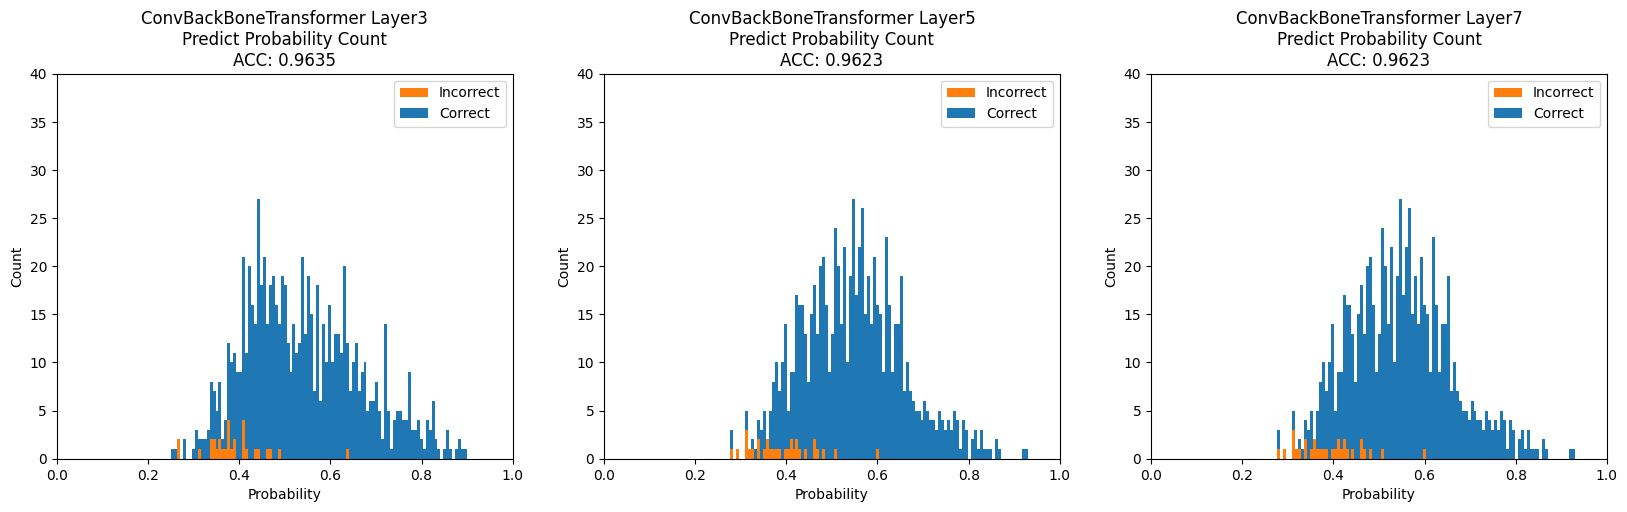

In [116]:
# 3枚描画空間を確保
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
x_limit = (0, 1)
y_limit = (0, 40)
x_label = 'Probability'
y_label = 'Count'
legend = ['Incorrect', 'Correct']

# 1枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer3'
df = convbbt_layer3_eval_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[0])
axes[0].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[0].legend(legend)
# 2枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer5'
df = convbbt_layer5_eval_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[1])
axes[1].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[1].legend(legend)
# 3枚目の描画空間に描画
title = 'ConvBackBoneTransformer Layer7'
df = convbbt_layer7_eval_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[2])
axes[2].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[2].legend(legend)

plt.show()

## Stacked Count

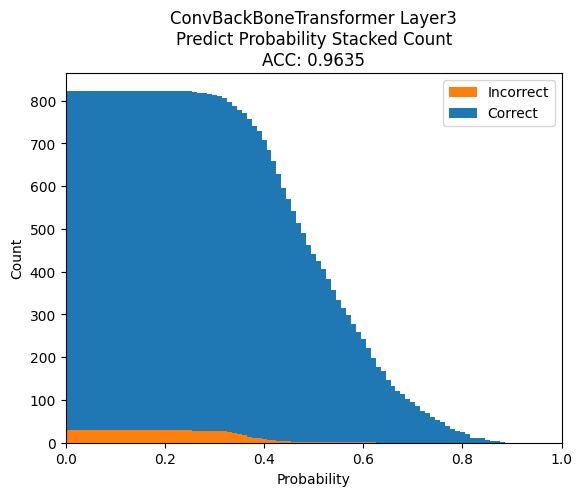

In [117]:
show_count_stacked(convbbt_layer3_eval_df, 'ConvBackBoneTransformer Layer3')

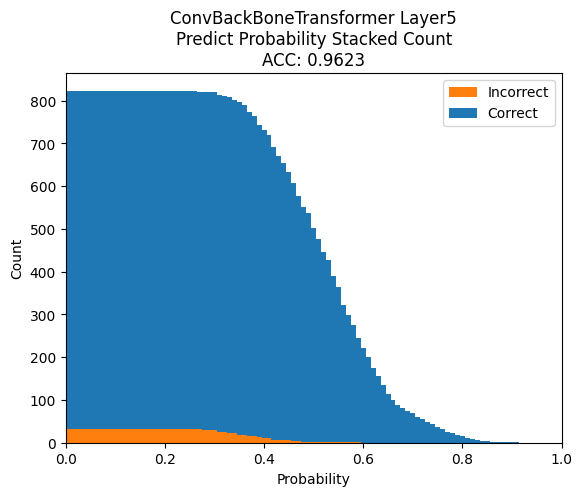

In [118]:
show_count_stacked(convbbt_layer5_eval_df, 'ConvBackBoneTransformer Layer5')

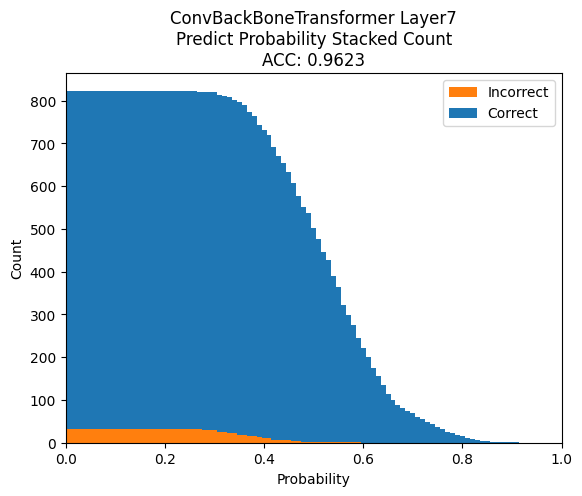

In [119]:
show_count_stacked(convbbt_layer7_eval_df, 'ConvBackBoneTransformer Layer7')

# Ensamble Model

## 1. Sum of Probabilities Ensamble

In [120]:
ensamble1_name = 'Sum-of-Probability-Ensamble'

In [121]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
ensamble1_df = convbbt_layer3_test_df.loc[:, LABELS].copy() + convbbt_layer5_test_df.loc[:, LABELS].copy() + convbbt_layer7_test_df.loc[:, LABELS].copy()
ensamble1_df = ensamble1_df.apply(lambda x: x / x.sum(), axis=1)
ensamble1_df["predict_probability"] = ensamble1_df.max(axis=1)
ensamble1_df["predict_label"] = ensamble1_df.idxmax(axis=1)
ensamble1_df['true_label'] = true_label.map(lambda x: LABELS[x])

In [122]:
ensamble1_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
1909,0.197658,0.164197,0.000000,0.073067,0.063654,0.501424,0.501424,Walking,Walking
6069,0.521029,0.031317,0.041579,0.020728,0.243692,0.141654,0.521029,Downstairs,Downstairs
6457,0.255486,0.046920,0.078245,0.000000,0.148126,0.471223,0.471223,Walking,Walking
615,0.202470,0.085259,0.000000,0.090984,0.118032,0.503254,0.503254,Walking,Walking
7922,0.156986,0.059924,0.000000,0.197726,0.476356,0.109009,0.476356,Upstairs,Upstairs


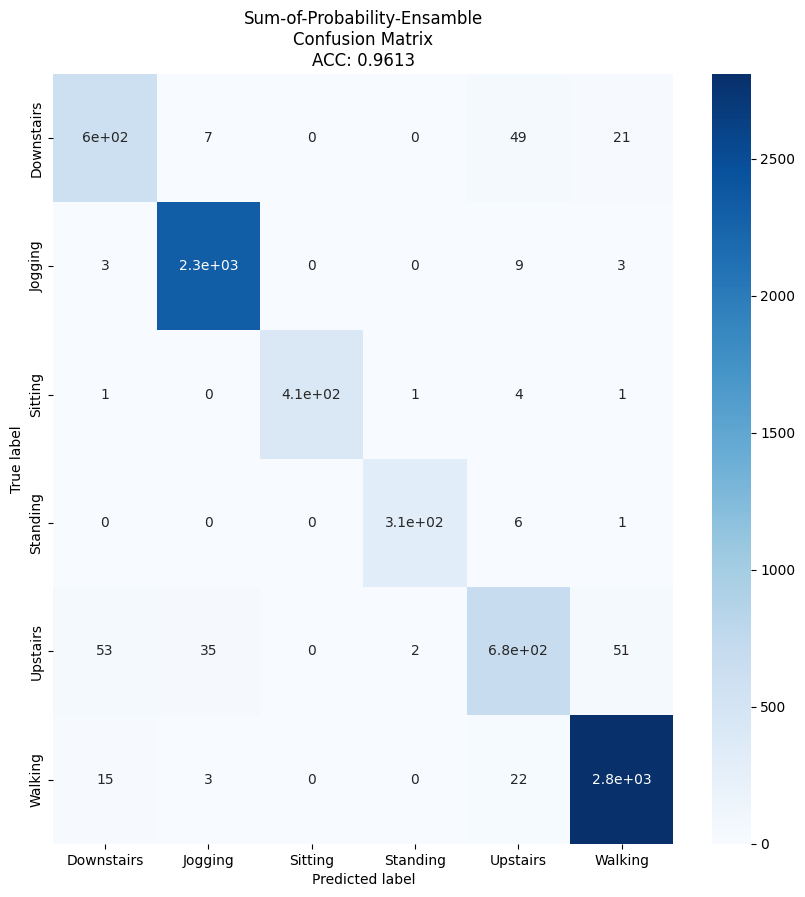

In [123]:
show_confusion_matrix(ensamble1_df, ensamble1_name)

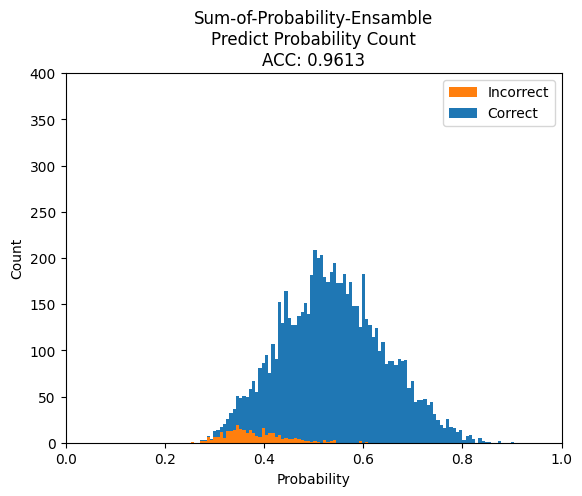

In [124]:
show_count(ensamble1_df, ensamble1_name)

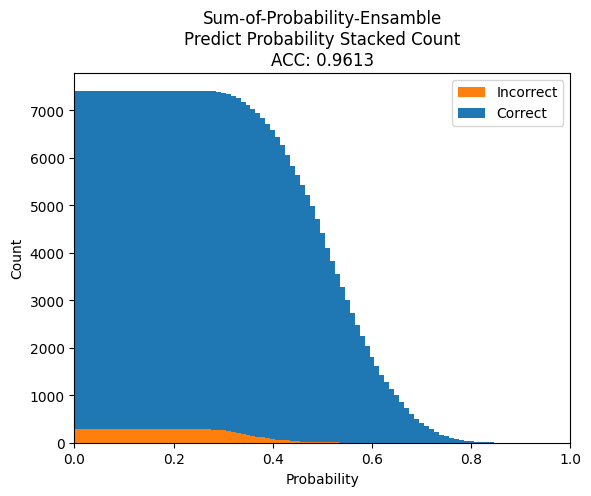

In [125]:
show_count_stacked(ensamble1_df, ensamble1_name)

In [126]:
print(f'Accuracy: {calc_accuracy(ensamble1_df):.4f}')
print(f'incorrect index num: {len(ensamble1_df.loc[ensamble1_df.true_label!=ensamble1_df.predict_label])}')
print("-"*50)
ensamble1_df.loc[ensamble1_df.predict_label!=ensamble1_df.true_label,"predict_label"].value_counts()

Accuracy: 0.9613
incorrect index num: 287
--------------------------------------------------


Upstairs      90
Walking       77
Downstairs    72
Jogging       45
Standing       3
Name: predict_label, dtype: int64

In [127]:
calc_thredshold_df(ensamble1_df)

/tmp/ipykernel_11705/3638897595.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.0,0.961289,7414
0.1,0.961289,7414
0.2,0.961289,7414
0.3,0.963058,7390
0.4,0.985399,6712
0.5,0.996823,4721
0.6,0.999509,2035
0.7,1.000000,496
0.8,1.000000,34


## 2. Vote Ensamble

In [128]:
ensamble2_name = 'Vote-Ensamble'

In [129]:
modelnames = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
ensamble2_label_df = pd.concat([convbbt_layer3_test_df.loc[:, "predict_label"].copy(), convbbt_layer5_test_df.loc[:, "predict_label"].copy(), convbbt_layer7_test_df.loc[:, "predict_label"].copy()], axis=1)
ensamble2_probability_df= pd.concat([convbbt_layer3_test_df.loc[:, "predict_probability"].copy(), convbbt_layer5_test_df.loc[:, "predict_probability"].copy(), convbbt_layer7_test_df.loc[:, "predict_probability"].copy()], axis=1)
ensamble2_label_df.columns = modelnames
ensamble2_probability_df.columns = modelnames
ensamble2_df = pd.DataFrame({
                        "predict_label": ensamble2_label_df.apply(lambda x: x.value_counts().idxmax(), axis=1),
                        "predict_probability": ensamble2_probability_df.max(axis=1),
                        "true_label": true_label.map(lambda x: LABELS[x]), "predict_probability": ensamble2_probability_df.max(axis=1),
                        })

In [130]:
ensamble2_df.head()

,predict_label,predict_probability,true_label
0,Walking,0.328387,Walking
1,Sitting,0.490490,Sitting
2,Upstairs,0.347397,Upstairs
3,Jogging,0.585972,Jogging
4,Standing,0.643581,Standing


In [131]:
value_counts = ensamble2_label_df.apply(lambda x: x.value_counts(), axis=1)

vote_3_index = value_counts.loc[(value_counts == 3).apply(lambda x: any(x), axis=1),:].index
vote_2_index = value_counts.loc[(value_counts == 2).apply(lambda x: any(x), axis=1),:].index
vote_1_index = list(set(value_counts.loc[(value_counts == 1).apply(lambda x: any(x), axis=1),:].index) - set(vote_2_index))

vote_3 = pd.DataFrame({
                "predict_label": ensamble2_label_df.loc[vote_3_index,:].apply(lambda x: x.value_counts().idxmax(), axis=1), 
                "true_label": true_label.loc[vote_3_index].map(lambda x: LABELS[x])
                })
vote_2 = pd.DataFrame({
                "predict_label": ensamble2_label_df.loc[vote_2_index,:].apply(lambda x: x.value_counts().idxmax(), axis=1), 
                "true_label": true_label.loc[vote_2_index].map(lambda x: LABELS[x])
                })

vote_1 = pd.DataFrame({
                "predict_label": ensamble2_label_df.loc[vote_1_index,:].apply(lambda x: x.value_counts().idxmax(), axis=1), 
                "true_label": true_label.loc[vote_1_index].map(lambda x: LABELS[x])
                }) if len(vote_1_index)!=0 else pd.DataFrame()

In [132]:
print('All num: ', len(ensamble2_label_df))
print(f'Vote 3 num: {len(vote_3)}') 
print(f'Vote 2 num: {len(vote_2)}')
print(f'Vote 1 num: {len(vote_1)}')

All num:  7414
Vote 3 num: 7093
Vote 2 num: 321
Vote 1 num: 0


In [133]:
show_confusion_matrix(ensamble2_df, ensamble2_name)

TypeError: '<' not supported between instances of 'str' and 'float'

In [134]:
vote1_acc = calc_accuracy(vote_1)
vote2_acc = calc_accuracy(vote_2)
vote3_acc = calc_accuracy(vote_3)
plt.bar(["Vote1", "Vote2", "Vote3"], [vote1_acc, vote2_acc, vote3_acc])
plt.text(-0.1, vote1_acc+0.01, f'{vote1_acc:.4f}')
plt.text(0.9, vote2_acc+0.01, f'{vote2_acc:.4f}')
plt.text(1.9, vote3_acc+0.01, f'{vote3_acc:.4f}')
plt.title('Vote Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(f'assets/{ensamble2_name}-accuracy.png')
plt.show()

KeyError: 'true_label'

In [135]:
vote_321 = pd.concat([vote_3, vote_2, vote_1], axis=0).reset_index()
vote_32 = pd.concat([vote_3, vote_2], axis=0).reset_index()

vote_321_acc = calc_accuracy(vote_321)
vote_32_acc = calc_accuracy(vote_32)
plt.bar(["Vote321", "Vote32", "Vote3"], [vote_321_acc, vote_32_acc, vote3_acc])
plt.text(-0.1, vote_321_acc+0.01, f'{vote_321_acc:.4f}')
plt.text(0.9, vote_32_acc+0.01, f'{vote_32_acc:.4f}')
plt.text(1.9, vote3_acc+0.01, f'{vote3_acc:.4f}')
plt.title('Vote Accuracy Stacked')
plt.ylabel('Accuracy')
plt.ylim(0,1.1)
plt.savefig(f'assets/{ensamble2_name}-accuracy-stacked.png')
plt.show()


NameError: name 'vote3_acc' is not defined

In [ ]:
print(f'Accuracy: {calc_accuracy(ensamble2_df):.4f}')
print(f'incorrect index num: {len(ensamble2_df.loc[ensamble2_df.true_label!=ensamble2_df.predict_label])}')
print("-"*50)
ensamble2_df.loc[ensamble2_df.predict_label!=ensamble2_df.true_label,"predict_label"].value_counts()

Accuracy: 0.9632
incorrect index num: 303
--------------------------------------------------


predict_label
Walking       88
Downstairs    87
Upstairs      86
Jogging       37
Standing       4
Sitting        1
Name: count, dtype: int64

## 3. Max of Probability Ensamble

In [136]:
ensamble3_name = 'Max-of-Probability-Ensamble'

In [137]:
modelnames = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
ensamble3_label_df = pd.concat([convbbt_layer3_test_df.loc[:, "predict_label"].copy(), convbbt_layer5_test_df.loc[:, "predict_label"].copy(), convbbt_layer7_test_df.loc[:, "predict_label"].copy()], axis=1)
ensamble3_probability_df= pd.concat([convbbt_layer3_test_df.loc[:, "predict_probability"].copy(), convbbt_layer5_test_df.loc[:, "predict_probability"].copy(), convbbt_layer7_test_df.loc[:, "predict_probability"].copy()], axis=1)
ensamble3_label_df.columns = modelnames
ensamble3_probability_df.columns = modelnames
ensamble3_df = pd.DataFrame({
                        "predict_label": ensamble3_probability_df.apply(lambda x: x.idxmax(), axis=1),
                        "predict_probability": ensamble3_probability_df.max(axis=1),
                        "predict_from": ensamble3_probability_df.apply(lambda x: x.idxmax(), axis=1),
                        "true_label": true_label.map(lambda x: LABELS[x]),
                        })
refcol = ensamble3_probability_df.apply(lambda x: x.idxmax(), axis=1)
for i in range(len(ensamble3_probability_df)):
    ensamble3_df.loc[i,"predict_label"] = ensamble3_label_df.loc[i, refcol.iloc[i]]

KeyError: 35

In [ ]:
ensamble3_df.head()

,predict_label,predict_probability,predict_from,true_label
0,Walking,0.404205,ConvBackBoneTransformer Layer7,Walking
1,Sitting,0.490490,ConvBackBoneTransformer Layer5,Sitting
2,Upstairs,0.351279,ConvBackBoneTransformer Layer7,Upstairs
3,Jogging,0.647780,ConvBackBoneTransformer Layer7,Jogging
4,Standing,0.643581,ConvBackBoneTransformer Layer5,Standing


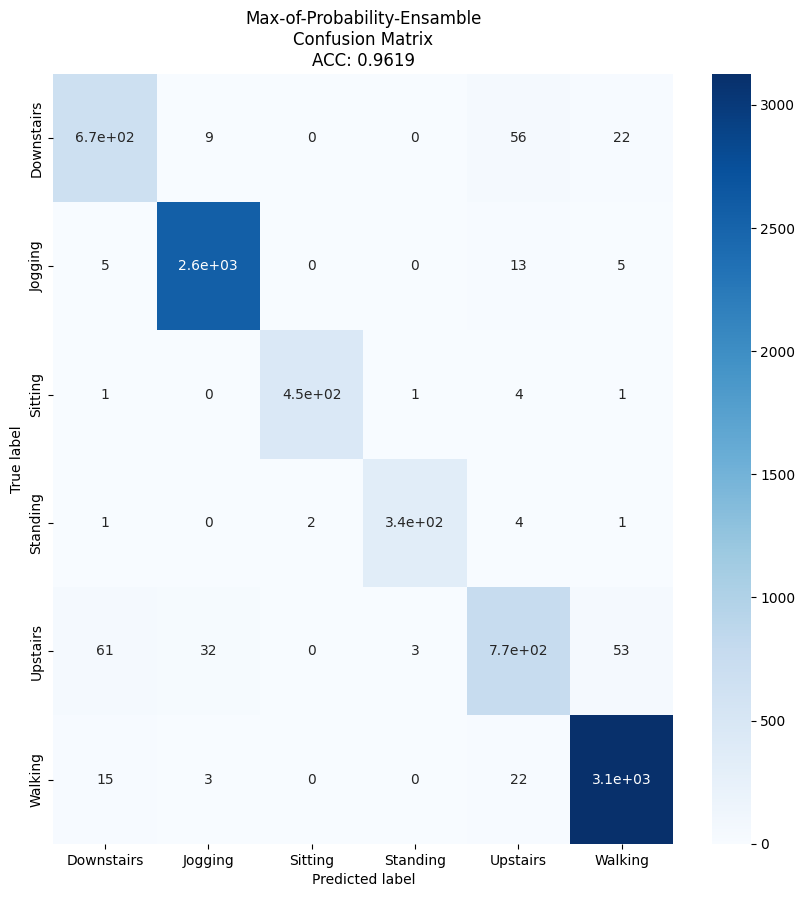

In [ ]:
show_confusion_matrix(ensamble3_df, ensamble3_name)

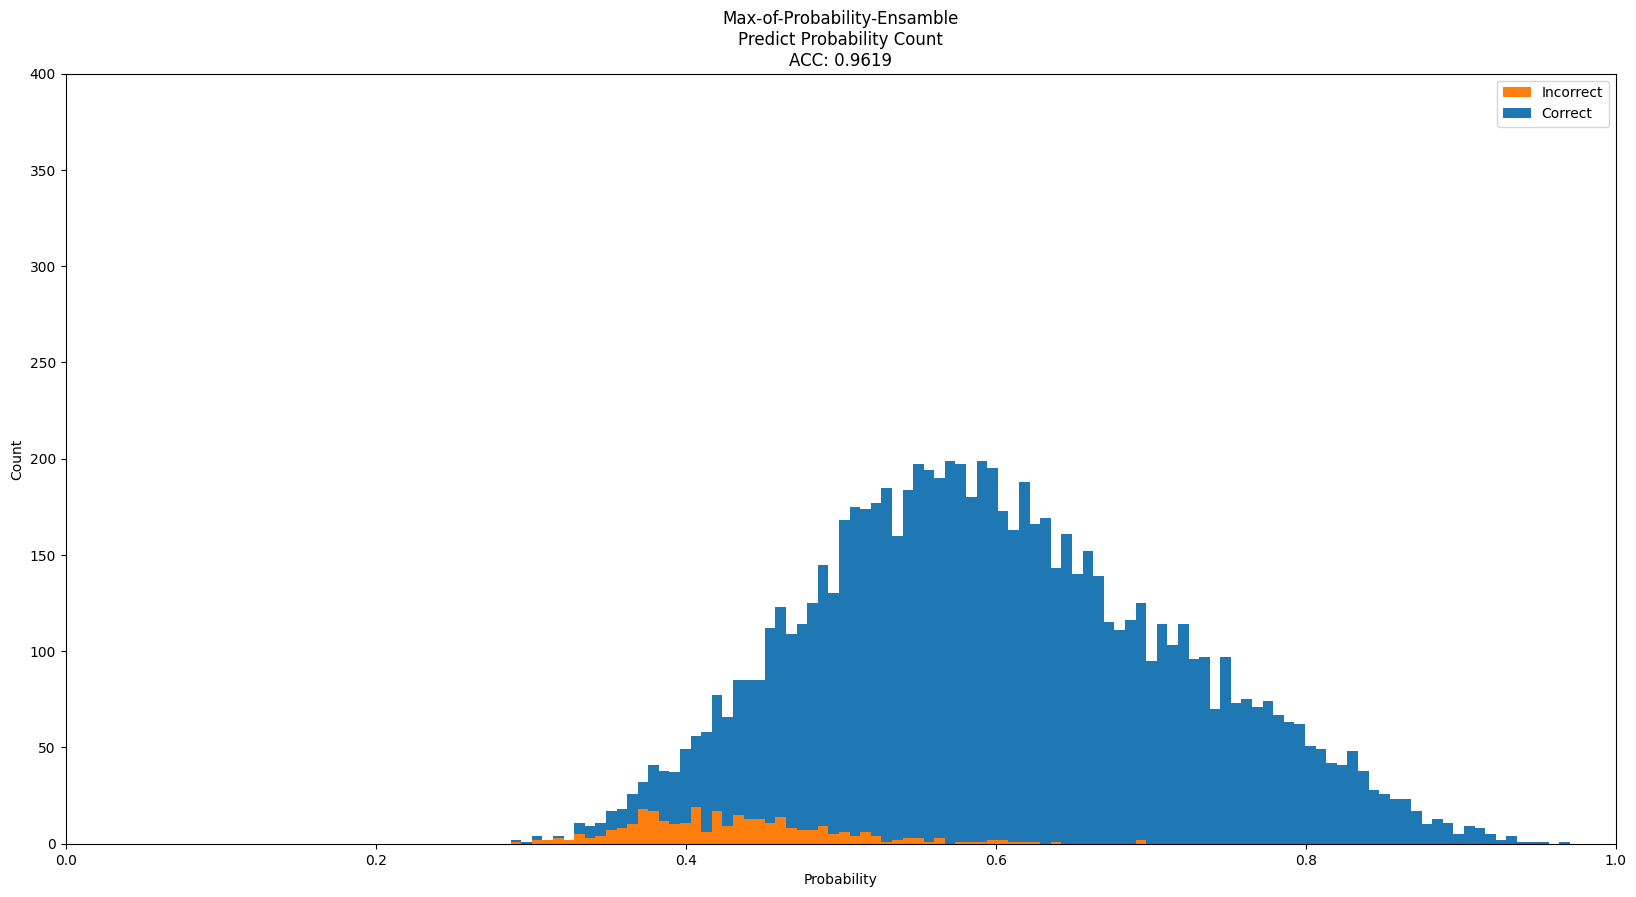

In [ ]:
show_count(ensamble3_df, ensamble3_name)

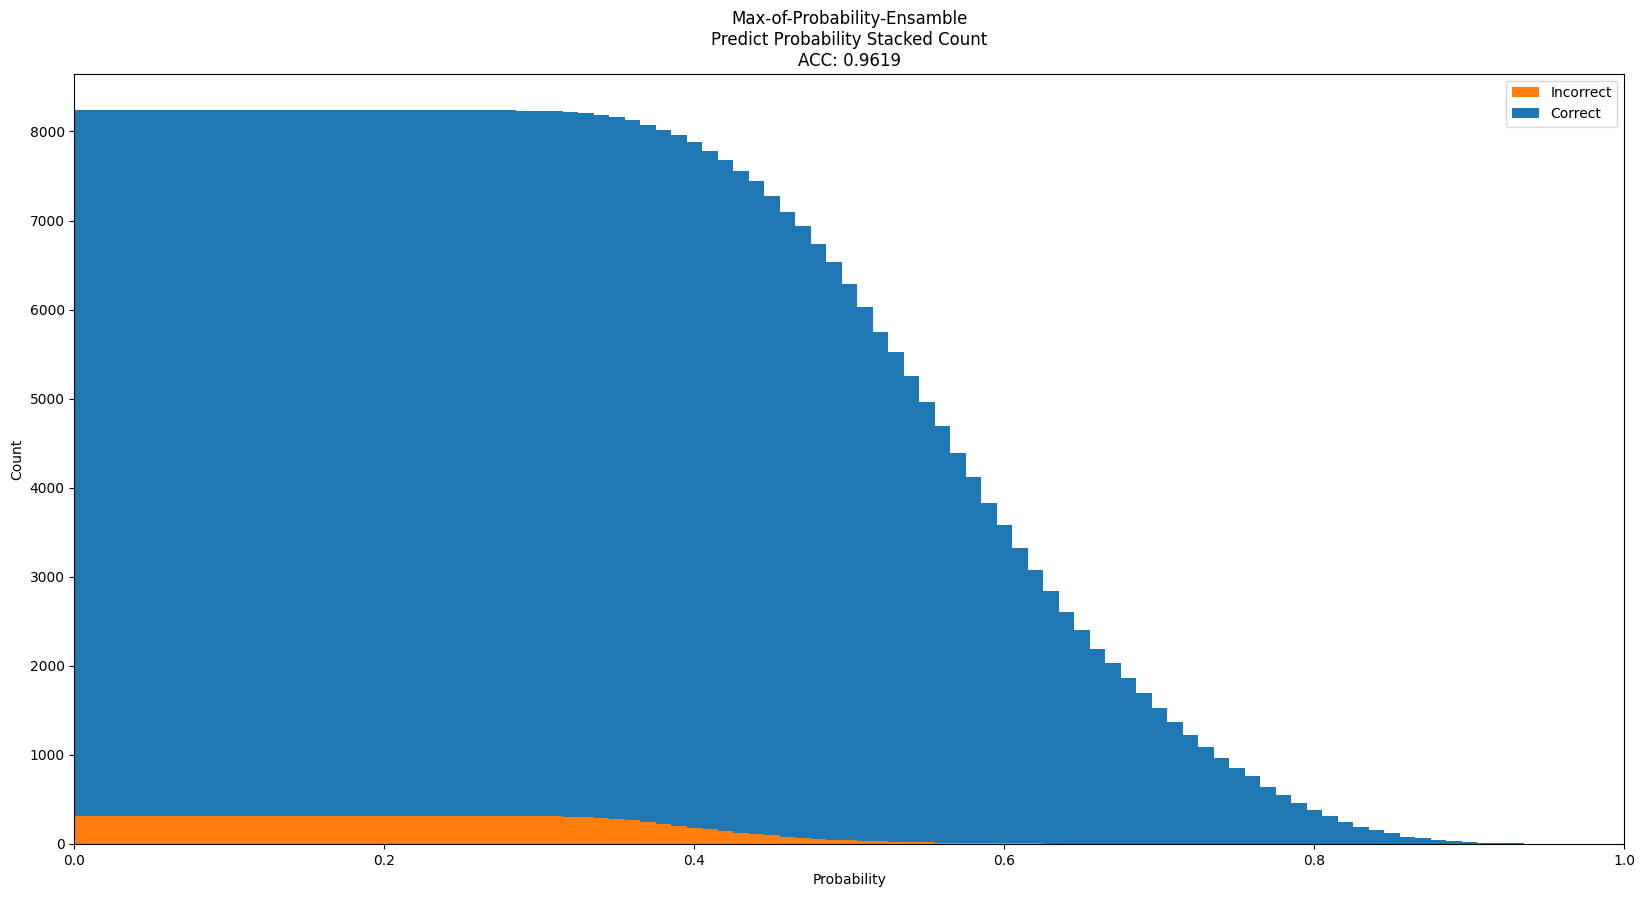

In [ ]:
show_count_stacked(ensamble3_df, ensamble3_name)

In [ ]:
print(f'Accuracy: {calc_accuracy(ensamble3_df):.4f}')
print(f'incorrect index num: {len(ensamble3_df.loc[ensamble3_df.true_label!=ensamble3_df.predict_label])}')
print("-"*50)
ensamble3_df.loc[ensamble3_df.predict_label!=ensamble3_df.true_label,"predict_label"].value_counts()

Accuracy: 0.9619
incorrect index num: 314
--------------------------------------------------


predict_label
Upstairs      99
Downstairs    83
Walking       82
Jogging       44
Standing       4
Sitting        2
Name: count, dtype: int64

In [ ]:
calc_thredshold_df(ensamble3_df)

/tmp/ipykernel_5874/167466859.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.0,0.961879,8237
0.1,0.961879,8237
0.2,0.961879,8237
0.3,0.961991,8235
0.4,0.974610,7956
0.5,0.992965,6539
0.6,0.997646,3823
0.7,1.000000,1690
0.8,1.000000,455


## 4. Handle Ensamble

In [138]:
ensamble4_name = 'Handle-Ensamble'

In [139]:
calc_thredshold_df(convbbt_layer3_eval_df)

/tmp/ipykernel_11705/3638897595.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.0,0.963548,823
0.1,0.963548,823
0.2,0.963548,823
0.3,0.965686,816
0.4,0.984890,728
0.5,0.997840,463
0.6,0.996139,259
0.7,1.000000,103
0.8,1.000000,27


In [140]:
calc_thredshold_df(convbbt_layer5_eval_df)

/tmp/ipykernel_11705/3638897595.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.0,0.962333,823
0.1,0.962333,823
0.2,0.962333,823
0.3,0.964591,819
0.4,0.981157,743
0.5,0.996269,536
0.6,0.995918,245
0.7,1.000000,75
0.8,1.000000,17


In [141]:
calc_thredshold_df(convbbt_layer7_eval_df)

/tmp/ipykernel_11705/3638897595.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.0,0.962333,823
0.1,0.962333,823
0.2,0.962333,823
0.3,0.964591,819
0.4,0.981157,743
0.5,0.996269,536
0.6,0.995918,245
0.7,1.000000,75
0.8,1.000000,17


In [142]:
convbbt_layer3_threshold = 0.5
convbbt_layer5_threshold = 0.5
convbbt_layer7_threshold = 0.5

In [143]:
calc_accuracy(convbbt_layer3_eval_df.loc[convbbt_layer3_eval_df.predict_probability>convbbt_layer3_threshold,:])

0.9978401727861771

In [144]:
calc_accuracy(convbbt_layer5_eval_df.loc[convbbt_layer5_eval_df.predict_probability>convbbt_layer5_threshold,:])

0.996268656716418

In [145]:
calc_accuracy(convbbt_layer7_eval_df.loc[convbbt_layer7_eval_df.predict_probability>convbbt_layer7_threshold,:])

0.996268656716418

In [146]:
# importance in descending order

# convbbt_layer7
ensamble4_df = convbbt_layer7_test_df.copy()
ensamble4_df.loc[:,"method"] = "ConvBackBoneTransformer Layer7"

# Vote3
vote3_index = (convbbt_layer3_test_df.predict_label == convbbt_layer5_test_df.predict_label) & (convbbt_layer5_test_df.predict_label == convbbt_layer7_test_df.predict_label)
ensamble4_df.loc[vote3_index,:] = convbbt_layer7_test_df.loc[vote3_index,:]
ensamble4_df.loc[vote3_index,"method"] = "Vote3"

# confidence-line
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_threshold,:] = convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>0.5,:]
ensamble4_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_threshold,"method"] = "ConvBackBoneTransformer Layer3(confidence-line)"
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_threshold,:] = convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>0.5,:]
ensamble4_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_threshold,"method"] = "ConvBackBoneTransformer Layer5(confidence-line)"
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_threshold,:] = convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>0.5,:]
ensamble4_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_threshold,"method"] = "ConvBackBoneTransformer Layer7(confidence-line)"


In [147]:
ensamble4_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label,method
1909,0.199085,0.159620,0.000000,0.076418,0.014528,0.550348,0.550348,Walking,Walking,ConvBackBoneTransformer Layer7(confidence-line)
6069,0.588914,0.046976,0.000000,0.011841,0.217139,0.135131,0.588914,Downstairs,Downstairs,ConvBackBoneTransformer Layer7(confidence-line)
6457,0.302001,0.037164,0.033318,0.000000,0.145008,0.482508,0.482508,Walking,Walking,Vote3
615,0.206700,0.090799,0.000000,0.094498,0.099321,0.508683,0.508683,Walking,Walking,ConvBackBoneTransformer Layer7(confidence-line)
7922,0.162153,0.076311,0.000000,0.190325,0.501428,0.069783,0.501428,Upstairs,Upstairs,ConvBackBoneTransformer Layer7(confidence-line)


In [148]:
ensamble4_df["method"].value_counts()

ConvBackBoneTransformer Layer7(confidence-line)    4696
Vote3                                              1627
ConvBackBoneTransformer Layer3(confidence-line)     803
ConvBackBoneTransformer Layer7                      288
Name: method, dtype: int64

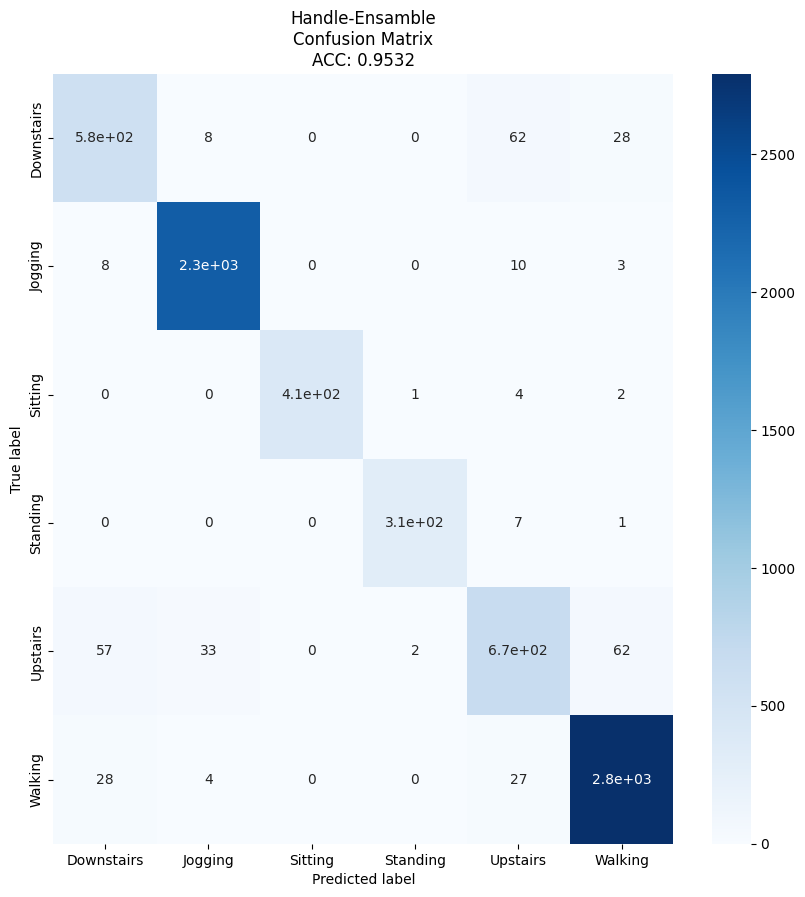

In [149]:
show_confusion_matrix(ensamble4_df, ensamble4_name)

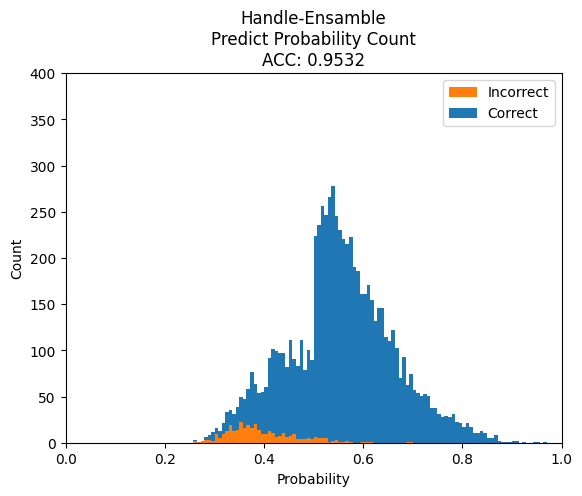

In [150]:
show_count(ensamble4_df, ensamble4_name)

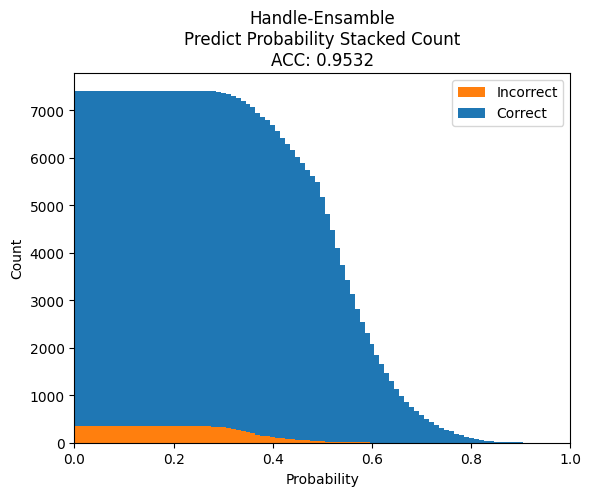

In [151]:
show_count_stacked(ensamble4_df, ensamble4_name)

In [152]:
print(f'Accuracy: {calc_accuracy(ensamble4_df):.4f}')
print(f'incorrect index num: {len(ensamble4_df.loc[ensamble4_df.true_label!=ensamble4_df.predict_label])}')
print("-"*50)
ensamble4_df.loc[ensamble4_df.predict_label!=ensamble4_df.true_label,"predict_label"].value_counts()

Accuracy: 0.9532
incorrect index num: 347
--------------------------------------------------


Upstairs      110
Walking        96
Downstairs     93
Jogging        45
Standing        3
Name: predict_label, dtype: int64

In [153]:
calc_thredshold_df(ensamble4_df)

/tmp/ipykernel_11705/3638897595.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.0,0.953197,7414
0.1,0.953197,7414
0.2,0.953197,7414
0.3,0.954761,7383
0.4,0.979973,6791
0.5,0.993090,5499
0.6,0.997839,2314
0.7,1.000000,661
0.8,1.000000,129


In [154]:
# del base prediction
print(f"dropped {len(ensamble4_df.loc[ensamble4_df.method=='ConvBackBoneTransformer Layer7',:])} rows")
calc_accuracy(ensamble4_df.loc[ensamble4_df.method!="ConvBackBoneTransformer Layer7",:])

dropped 288 rows


0.977266348582655

In [155]:
# del base prediction
print(f"dropped {len(ensamble4_df.loc[(ensamble4_df.method=='ConvBackBoneTransformer Layer7')|(ensamble4_df.method=='Vote3'),:])} rows")
calc_accuracy(ensamble4_df.loc[(ensamble4_df.method!="ConvBackBoneTransformer Layer7")&(ensamble4_df.method!="Vote3"),:])

dropped 1915 rows


0.9930896526641207

In [156]:
print(f"picked {len(ensamble4_df.loc[ensamble4_df.method=='Vote3',:])} rows")
calc_accuracy(ensamble4_df.loc[ensamble4_df.method=="Vote3",:])

picked 1627 rows


0.9237861094038107

In [157]:
print(f"picked {len(ensamble4_df.loc[ensamble4_df.method=='ConvBackBoneTransformer Layer7',:])} rows")
calc_accuracy(ensamble4_df.loc[ensamble4_df.method=="ConvBackBoneTransformer Layer7",:])

picked 288 rows


0.3576388888888889

Text(0.5, 1.0, '99% Confidence-Line Venn Diagram\n    ACC: 0.9931\n    rest: 1915\n    ')

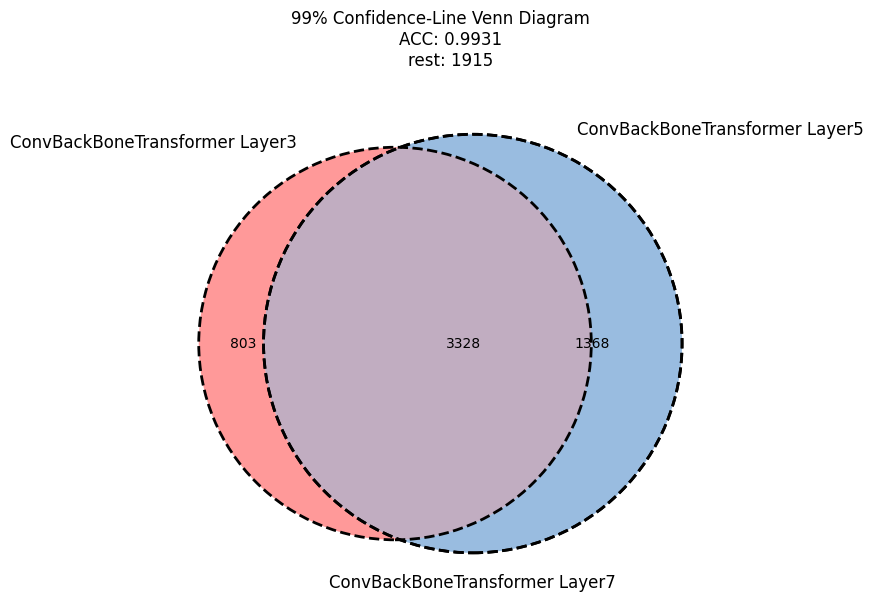

In [160]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

def draw_venn(sets:list, labels:list=None):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    venn = venn3(sets, set_labels = labels)
    venn_circles = venn3_circles([set(s) for s in sets], linestyle='dashed')

# confidence-line
model1_set = set(convbbt_layer3_test_df.loc[convbbt_layer3_test_df.predict_probability>convbbt_layer3_threshold,:].index)
model2_set = set(convbbt_layer5_test_df.loc[convbbt_layer5_test_df.predict_probability>convbbt_layer5_threshold,:].index)
model3_set = set(convbbt_layer7_test_df.loc[convbbt_layer7_test_df.predict_probability>convbbt_layer7_threshold,:].index)

model_labels = ["ConvBackBoneTransformer Layer3", "ConvBackBoneTransformer Layer5", "ConvBackBoneTransformer Layer7"]
model_sets = [model1_set, model2_set, model3_set]

draw_venn(model_sets, model_labels)
plt.title(
    f'''99% Confidence-Line Venn Diagram
    ACC: {calc_accuracy(ensamble4_df.loc[(ensamble4_df.method!="ConvBackBoneTransformer Layer7")&(ensamble4_df.method!="Vote3"),:]):.4f}
    rest: {len(ensamble4_df)-len(ensamble4_df.loc[(ensamble4_df.method!="ConvBackBoneTransformer Layer7")&(ensamble4_df.method!="Vote3"),:])}
    ''')
